# Задача

Натренировать претренированные VGG16 и ResNet50 модели решать регрессионные задачи. Например, в случае с набором данных в этом коде, определять рейтинг качества картинки. 

Набор данных http://database.mmsp-kn.de/koniq-10k-database.html

Насколько я понимаю, модель не обучается, так как Mean Squared Error набора данных для валидации колеблется в каком-то пределе вместо того, чтобы уменьшаться.

Если возможно обучить модель решать подобную задачу, хотелось бы, чтобы модель обучалась.

In [ ]:
!wget http://datasets.vqa.mmsp-kn.de/archives/koniq10k_scores_and_distributions.zip

In [ ]:
!wget http://datasets.vqa.mmsp-kn.de/archives/koniq10k_512x384.zip

In [ ]:
! mkdir images

In [ ]:
!unzip koniq10k_scores_and_distributions.zip

In [ ]:
!unzip koniq10k_512x384.zip -d images

In [ ]:
import pandas as pd
df=pd.read_csv('/content/koniq10k_scores_and_distributions.csv',dtype=str)

traindf = df.drop(df.columns[[1, 2, 3, 4, 5, 6, 8, 9]], axis=1)

#def append_ext(fn):
#    return fn+".jpg"

#traindf["image_name"]=traindf["image_name"].apply(append_ext)

traindf["MOS"]=traindf["MOS"].astype(float)
#.astype(float)
print(traindf)
print(traindf["MOS"][4])

In [ ]:
from keras.applications.vgg16 import VGG16
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt


img_height = 224
img_width = 224   
train_dir = "/content/images/512x384"
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_generator = train_datagen.flow_from_dataframe(
    directory=train_dir,
    dataframe=traindf,
    x_col="image_name",
    y_col="MOS",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_dataframe(
    directory=train_dir, # same directory as training data
    dataframe=traindf,
    x_col="image_name",
    y_col="MOS",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw',
    subset='validation') # set as validation data

for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)   #  (1,224,224,3)
    plt.imshow(img[0])
    plt.show()
    print(label[0])

In [ ]:
print(device_lib.list_local_devices())

#model = VGG16()
#model.summary()


conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_height, img_width, 3))
print(conv_base.summary())
print("----------------------------------")
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.Dense(2048, activation='relu'))
#model.add(layers.Dense(1024, activation='relu'))
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))     #model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))      #model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='linear'))     #model.add(layers.Dense(1, activation='linear'))

conv_base.trainable = False

model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer="Adam",
              metrics=[keras.metrics.MeanAbsoluteError()])


model.summary()

In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    verbose=1,
    use_multiprocessing=True
)

In [ ]:
import numpy as np

img, label = validation_generator.next()
#img, label = train_generator.next()
print(img[0].shape)   #  (1,256,256,3)
plt.imshow(img[0])
plt.show()
print(label[0])
print("--------")
print("Predicted:")
im = np.expand_dims(img[0], axis=0)
print(model.predict(im))

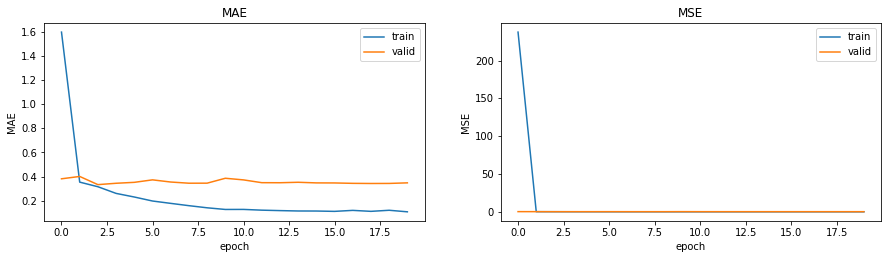

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['mean_absolute_error'])  
plt.plot(history.history['val_mean_absolute_error'])  
plt.title('MAE')  
plt.ylabel('MAE')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('MSE')  
plt.ylabel('MSE')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()